In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain.memory import ConversationBufferMemory
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_community.llms import Ollama
from langchain_ollama import OllamaLLM
# AgentState structure
import logging

# Logları kaydetmek için dosya ayarı
logging.basicConfig(
    filename="logs.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    encoding="utf-8"
)

def log_event(event_type: str, message: str):
    """
    event_type: INFO, ERROR, WARNING gibi log türleri
    message: Loglanacak mesaj
    """
    if event_type == "INFO":
        logging.info(message)
    elif event_type == "ERROR":
        logging.error(message)
    elif event_type == "WARNING":
        logging.warning(message)
    else:
        logging.debug(message)  # Varsayılan olarak debug seviyesinde log tut


class AgentState(TypedDict):
    user_query: str
    retrieved_docs: List[str]
    response: str
    chat_history: str

# Hafıza ve vektör veritabanı yüklemeliyim Unutma !
DB_NAME = "vector-db"
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma(persist_directory=DB_NAME, embedding_function=embeddings)
retriever = vectorstore.as_retriever()
llm = Ollama(model="llama3.2")
memory = ConversationBufferMemory()

# (Nodes)
def user_input_node(state: AgentState):
    #query alır
    return {"user_query": state["user_query"]}

def retrieve_node(state: AgentState):
    #vector dbden alakalıları çekterim
    retrieved_docs = vectorstore.similarity_search(state["user_query"], k=10)
    return {"retrieved_docs": [doc.page_content for doc in retrieved_docs]}

def generate_response_node(state: AgentState):
    #cevabı generate ettiririm
    combined_context = "\n".join(state["retrieved_docs"])
    prompt = f"""
    You are a telecom assistant. Your answers should be based on the retrieved context below.
    
    Context: {combined_context}
    
    Question: {state['user_query']}
    
    Answer:
    """
    response = llm.invoke(prompt)
    return {"response": response}

def update_memory_node(state: AgentState):
    #konuşma geçmişini güncellerim
    memory.save_context({"input": state["user_query"]}, {"output": state["response"]})
    return {"chat_history": memory.load_memory_variables({}).get("history", "")}

# StateGraph 
builder = StateGraph(AgentState)
builder.add_node("user_input", user_input_node)
builder.add_node("retrieve", retrieve_node)
builder.add_node("generate_response", generate_response_node)
builder.add_node("update_memory", update_memory_node)


builder.set_entry_point("user_input")
builder.add_edge("user_input", "retrieve")
builder.add_edge("retrieve", "generate_response")
builder.add_edge("generate_response", "update_memory")
builder.add_edge("update_memory", END)


rag_graph = builder.compile()


/tmp/ipykernel_4727/4248462707.py:22: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.2")
/tmp/ipykernel_4727/4248462707.py:23: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()


## stategraph with grader

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain.memory import ConversationBufferMemory
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import Ollama
from langchain.document_loaders import PyMuPDFLoader
import logging


import logging

# Logları kaydetmek için dosya ayarı
logging.basicConfig(
    filename="logs.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    encoding="utf-8"
)

def log_event(event_type: str, message: str):
    """
    event_type: INFO, ERROR, WARNING gibi log türleri
    message: Loglanacak mesaj
    """
    if event_type == "INFO":
        logging.info(message)
    elif event_type == "ERROR":
        logging.error(message)
    elif event_type == "WARNING":
        logging.warning(message)
    else:
        logging.debug(message)  # Varsayılan olarak debug seviyesinde log tut



# Grader için Prompt
GRADER_PROMPT_TEMPLATE = """
You are an expert evaluator. Grade the response based on the following criteria:
1. Groundedness: Does the response fully address the question using the provided context?
2. Answer Relevance: Is the response relevant and directly answering the question?
3. Context Relevance: Is the response actually correct based on the context?

Context:
{context}

Question:
{question}

Response:
{response}

---

Provide a float score from 0 to 1 for each criteria and a short explanation for the score.
"""

class Grader:
    def __init__(self):
        self.model = Ollama(model="llama3.2")  # Grading LLM

    def grade(self, context: str, question: str, response: str) -> str:
        prompt_template = ChatPromptTemplate.from_template(GRADER_PROMPT_TEMPLATE)
        prompt = prompt_template.format(
            context=context, question=question, response=response
        )
        return self.model.invoke(prompt)

# AgentState yapısı
class AgentState(TypedDict):
    user_query: str
    retrieved_docs: List[str]
    response: str
    chat_history: str
    evaluation_score: float

class ModelHandler:
    def __init__(self):
        self.models = {
            "telecom": Ollama(model="llama3.2"),
            "code": Ollama(model="codellama"),
            "summary": Ollama(model="mistral")
        }
        self.classifier = Ollama(model="llama3.2")  # LLM Model for classifying

    def classify_query(self, query: str) -> str:
        """Use LLM to classify the query into 'telecom', 'code', or 'summary'."""
        classification_prompt = f"""
        Given the following user query, classify it into one of the following categories:
        - "telecom" if it is related to telecommunications, networking, 5G, or telecom industry topics.
        - "code" if it is related to programming, coding, functions, scripts, or software development.
        - "summary" if it asks for summarization, explanation, or TL;DR-style content.

        Query: "{query}"

        Respond with only one word: 'telecom', 'code', or 'summary'.
        """

        response = self.classifier.generate([classification_prompt])
        category = response.generations[0][0].text.strip().lower() 
        
        # Güvenlik kontrolü: Yanlış cevap dönerse default olarak telecom seç
        if category not in self.models:
            category = "telecom"

        return category


    
    def get_model(self, query: str):
        """Choose the best model based on LLM classification of the query."""
        category = self.classify_query(query)
        return self.models[category]


# Hafıza ve vektör veritabanı yükleme
DB_NAME = "vector-db"
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma(persist_directory=DB_NAME, embedding_function=embeddings)
retriever = vectorstore.as_retriever()
memory = ConversationBufferMemory()
grader = Grader()

# Düğümler (Nodes)
def user_input_node(state: AgentState):
    return {"user_query": state["user_query"]}

def retrieve_node(state: AgentState):
    retrieved_docs = vectorstore.similarity_search(state["user_query"], k=10)
    return {"retrieved_docs": [doc.page_content for doc in retrieved_docs]}

def generate_response_node(state: AgentState):
    combined_context = "\n".join(state["retrieved_docs"])
    model_handler = ModelHandler()
    # En uygun modeli seç
    model = model_handler.get_model(state["user_query"])
    
    prompt = f"""
    You are a telecom assistant. Your answers should be based on the retrieved context below.
    
    Context: {combined_context}
    
    Question: {state['user_query']}
    
    Answer:
    """
    try:
        response = model.invoke(prompt)
        log_event("INFO", f"Query: {state['user_query']} | Response: {response}")
        return {"response": response}
    except Exception as e:
        log_event("ERROR", f"Error while generating: {str(e)}")
        return {"error":  "Response not generated"}


THRESHOLD_SCORE = 0.7

def evaluate_response_node(state: AgentState):
    evaluation_result = grader.grade(
        context="\n".join(state["retrieved_docs"]),
        question=state["user_query"],
        response=state["response"]
    )
    
    print("Grader Output:", evaluation_result)  # Debug için çıktıyı yazdır
    
    score_values = []
    score_lines = evaluation_result.split("\n")
    
    for line in score_lines:
        if any(keyword in line for keyword in ["Overall Score", "Final Score", "Total Score"]):
            try:
                score = float(line.split(":")[1].strip().replace('*', ''))
                score_values.append(score)
            except (IndexError, ValueError):
                continue
    
    final_score = max(score_values, default=0.0)  # Eğer hiç uygun skor bulunmazsa 0.0 ata
    
    return {"evaluation_score": final_score}

def revise_response_node(state: AgentState):
    if state["evaluation_score"] < THRESHOLD_SCORE:
        print("Revizing response due to low score:", state["evaluation_score"])  # Debug için
        return {"response": generate_response_node(state)["response"]}
    return {}

def update_memory_node(state: AgentState):
    memory.save_context({"input": state["user_query"]}, {"output": state["response"]})
    return {"chat_history": memory.load_memory_variables({}).get("history", "")}


def add_pdf_node(state: AgentState):
    pdf_path = state.get("pdf_path")

    if not pdf_path:
        log_event("ERROR", "PDF path must not be null")
        return {"error": "❌ PDF path must not be null"}

    if not pdf_path.lower().endswith(".pdf"):
        log_event("ERROR", f"Uncorrect file format: {pdf_path}")
        return {"error": "❌ HATA: We only accept .pdf files."}

    try:
        add_pdf_to_vectorstore(pdf_path)
        log_event("INFO", f"{pdf_path} added succesfully")
        return {"success": f"✅ {pdf_path} added succesfully"}
    except Exception as e:
        log_event("ERROR", f"An error has occured while PDF file is uploaded. Exception: {str(e)}")
        return {"error": f"❌ HATA: An error has occured while PDF file is uploaded. Exception: {str(e)}"}


def remove_pdf_node(state: AgentState):
    pdf_filename = state.get("pdf_filename")
    if pdf_filename:
        remove_pdf_from_vectorstore(pdf_filename)
    return {}





def add_pdf_to_vectorstore(pdf_path: str):
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    
    # Belgelere metadata ekleme (dosya adı)
    for doc in documents:
        doc.metadata["source"] = pdf_path.split("/")[-1]  # Sadece dosya adını al
    
    vectorstore.add_documents(documents)
    vectorstore.persist()
    
    print(f"✅ {pdf_path} added successfully!")


def remove_pdf_from_vectorstore(pdf_filename: str):
    all_docs = vectorstore.get()
    
    # Silinecek belgeleri filtreleme
    doc_ids_to_remove = [doc["id"] for doc in all_docs["documents"] if doc["metadata"].get("source") == pdf_filename]
    
    if not doc_ids_to_remove:
        print(f"⚠️ {pdf_filename} not found in vectorstore.")
        return
    
    vectorstore.delete(doc_ids_to_remove)
    vectorstore.persist()
    
    print(f"❌ {pdf_filename} removed successfully!")






# StateGraph oluşturma
builder = StateGraph(AgentState)
builder.add_node("user_input", user_input_node)
builder.add_node("retrieve", retrieve_node)
builder.add_node("generate_response", generate_response_node)
builder.add_node("evaluate_response", evaluate_response_node)
builder.add_node("revise_response", revise_response_node)
builder.add_node("update_memory", update_memory_node)
builder.add_node("add_pdf", add_pdf_node)
builder.add_node("remove_pdf", remove_pdf_node)



# İş akışını belirleme
builder.set_entry_point("user_input")
builder.add_edge("user_input", "retrieve")
builder.add_edge("retrieve", "generate_response")
builder.add_edge("generate_response", "evaluate_response")
builder.add_conditional_edges(
    "evaluate_response", 
    lambda state: "revise_response" if state["evaluation_score"] < THRESHOLD_SCORE else "update_memory",
    {"revise_response": "revise_response", "update_memory": "update_memory"}
)

builder.add_edge("revise_response", "generate_response")
builder.add_edge("update_memory", END)
# Graph oluştur
rag_graph = builder.compile()

# Örnek çalıştırma


/tmp/ipykernel_16253/1382192472.py:122: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()
/tmp/ipykernel_16253/1382192472.py:61: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  self.model = Ollama(model="llama3.2")  # Grading LLM


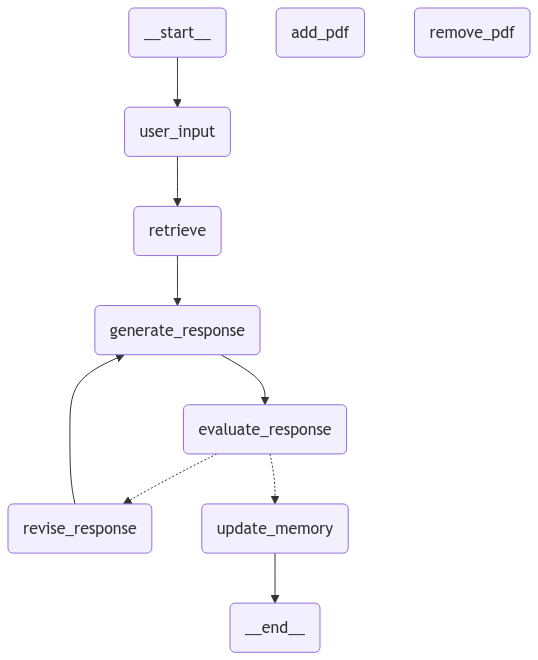

In [2]:
from IPython.display import Image, display
display(Image(rag_graph.get_graph().draw_mermaid_png()))

In [2]:
import gradio as gr

# Gradio üzerinden kullanıcının sorusunu alıp, modeli çalıştırıp sonucu döndüren fonksiyon
def chatbot_interface(user_query):
    state = {"user_query": user_query}
    
    # RAG Graph akışını çalıştır
    output = rag_graph.invoke(state)

    # Eğer hata varsa kullanıcıya göster
    if "error" in output:
        return output["error"]
    
    return output["response"]

# Gradio Arayüzü
iface = gr.Interface(
    fn=chatbot_interface,
    inputs="text",
    outputs="text",
    title="Telecom RAG Assistant",
    description="Telecom, kod ve özetleme destekli RAG tabanlı asistan",
    theme="default"
)

# Çalıştır
iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Grader Output: Here are my ratings for the 5G characteristics:

**Ultra-high speeds: 0.9**
This characteristic is already being achieved by some 5G networks, with download speeds reaching up to 20 Gbps in certain areas. However, this rate may not be consistent globally, and there may still be limitations on the availability of such high-speed connections.

**Low latency: 0.8**
While 5G promises low latency, actual performance can vary depending on factors like network congestion, distance from cell towers, and device capabilities. Some 5G networks have already achieved latency levels below 50 ms, but further improvements are still needed to reach the promised 1 ms.

**Massive connectivity: 0.7**
The ability of 5G to support a large number of devices is one of its key strengths, with some estimates suggesting that it can handle up to 1 million devices per square kilometer. However, this capacity may not be evenly distributed globally, and there may still be challenges in managing and ma

In [5]:
ModelHandler().classify_query("Generate script about 5G configurations")

'code'

In [ ]:
Oll